# Feynman-Kac Theorem: PDE and Stochastic Process

The Feynman–Kac links stochastic proces and PDE - European Option Case:

1) Monte Carlo (MC): used to simualated the stock following Black-Scholes assumptions
- Under the risk–neutral SDE --> simulate mamy paths forward in time
- Create random paths of the stock, discount payoffs, average and get V(S,0).
- Works in the probability space.

2) Finite Differences (FD): Crank-Nicolson used to solve the Black–Scholes PDE
- Propagate backward in time the value function V(S,t).
- Use calculus to determine V(S,0), without any random path.
- The PDE method works in the state space: it computes the expected value for every possible S at once.


In [1]:
# Parameters
import numpy as np
from typing import Tuple


# ATM Option
K, r, q, sigma, T =  100, 0.05, 0.0, 0.2, 1.0
S0 = 100.0

n_paths = 1000000
seed = 0

In [2]:
def european_call_mc(
        s0: float,
        K: float,
        r: float,
        q: float,
        sigma: float,
        T: float,
        n: int,
        seed: int) -> Tuple[float, np.ndarray]:
    
    rng = np.random.default_rng(seed=seed)
    Z = rng.standard_normal(size=n)
    ST = s0 * np.exp((r - q - 0.5 * sigma * sigma) * T + sigma * np.sqrt(T) * Z)
    payoff = np.maximum(ST - K, 0.0)
    price = np.exp(-r * T) * payoff.mean()
    
    ## Standard Error i.e. standard deviation of the mean
    # not on the price
    se = np.exp(-r * T) * payoff.std(ddof=1) / np.sqrt(n_paths) 
    return price, se

mc_price, mc_se = \
    european_call_mc(S0, K, r, q, sigma, T, n_paths, seed=seed)
print(f"MC price: {mc_price:.6f} ± {1.96*mc_se:.6f}")

MC price: 10.469705 ± 0.028882


In [3]:
# Crank–Nicolson
def bs_call_pde_fd_cn(
        S0: float, 
        K: float, 
        r: float, 
        q: float, 
        sigma: float, 
        T: float,
        Smax: float,     
        M: int = 300,           # 301 price points as default
        N: int = 300            # 301 time points as default
        ) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray]:
    
    Smax = S0*5
    # Space grid -> M --> i
    S = np.linspace(start=0.0, stop=Smax, num=M+1)
    
    # Time grid -> N --> n
    t = np.linspace( start=0.0, stop=T, num=N+1)
    dt = t[1]-t[0]
    
    # Terminal condition i.e. value of option at maturity
    # This is the starting point for the backward evolution.
    V = np.maximum(S - K, 0.0)  

    # Store the full surface for visualization
    V_surface = np.zeros((N+1, M+1))
    V_surface[-1, :] = V.copy()

    # Coefficient for Tridiagonal Matrix
    i = np.arange(start=1, stop=M)
    alpha = 0.25*dt*(sigma**2*(i**2) - (r-q)*i)
    beta  = -0.5*dt*(sigma**2*(i**2) + r)
    gamma = 0.25*dt*(sigma**2*(i**2) + (r-q)*i)

    # AVn=BVn+1
    # Asub​V^n_i−1​+Adiag​V^n_i​+Asup​V^n_i+1​ = Bsub​V^n+1_i−1​+Bdiag​V^n+1_n​+Bsup​V^n+1_i+1​.
    A_sub = -alpha.copy()
    A_diag = 1 - beta.copy()
    A_sup = -gamma.copy()

    B_sub = alpha.copy()
    B_diag = 1 + beta.copy()
    B_sup = gamma.copy()


    from numpy.linalg import solve
    # i --> space S (M)
    # n --> time t
    
    # We move backwards in time, starting from maturity (N) to now (0)
    for n in range(N, 0, -1):
        # At each iteration, we have the grid V^n+1 --> known from the next/later time
        # We compute V_n --> the unknown, earlier time by solving a linear system.

        # Build the right hand side of Crank-Nicholson (EXPLICIT)
        rhs = B_sub*V[i-1] + B_diag*V[i] + B_sup*V[i+1]
        
        # Boundary: V0 and Vmax are the known boundary values at this time level t_n
        t_now = (n-1)*dt
        # V(t_n,0)
        V0 = 0.0
        # V(t_n,S_max) --> linear, Using last value of S
        Vmax = S[-1]*np.exp(-q*(T - t_now)) - K*np.exp(-r*(T - t_now))

        # We "correct" the system to account for known edge values. 
        # Without this, the first and last interior equations would incorrectly include the unknown boundaries.
        rhs[0]  -= A_sub[0]*V0
        rhs[-1] -= A_sup[-1]*Vmax

        # Build IMPLICIT matrix
        # M-1 because solve only for interior nodes i=1...M-1 
        # since boundaries V0 and VM are known and excluded from the system 
        A = np.zeros((M-1, M-1))
        np.fill_diagonal(A, A_diag) # Central point
        np.fill_diagonal(A[1:], A_sub[1:]) # Forward neighbor
        np.fill_diagonal(A[:,1:], A_sup[:-1]) # Backward neighbor

        V_in = solve(A, rhs)

        # After each time n, full profile V_n=[V^0n_​,V^1_n​,…,V^M−1_n​,V^M_n​].
        V[0] = V0
        V[1:M] = V_in
        V[M] = Vmax

        V_surface[n-1, :] = V.copy()

    # Interpolate the option price at the current stock price
    # Value of option at time zero for S
    price = np.interp(S0, S, V)

    # V is just the last profile
    # V_surface contains all profiles
    
    return price, S, t, V, V_surface

fd_price, S_grid, t_grid, V_grid , V_surface = \
    bs_call_pde_fd_cn(S0, K, r, q, sigma, T, Smax=5*S0, M=500, N=500)
print(f"FD price: {fd_price:.6f}")

FD price: 10.448113


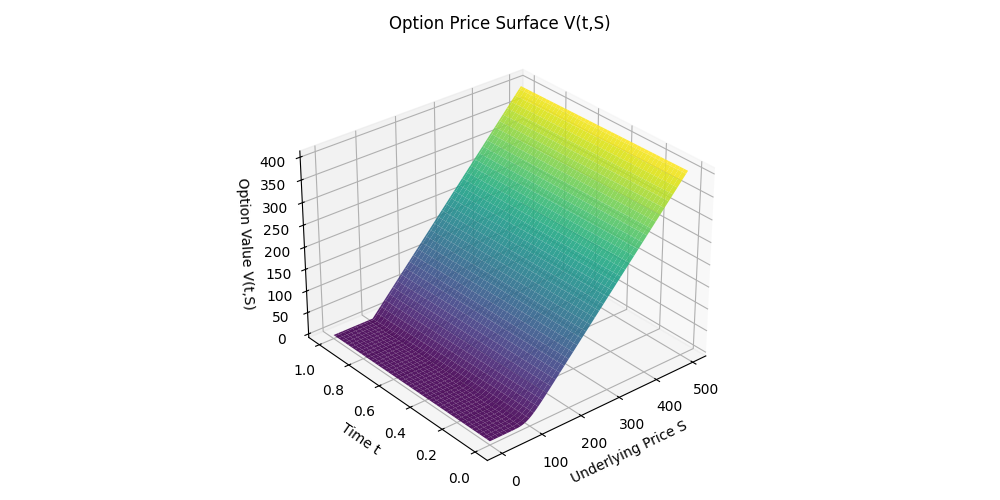

In [4]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

T_mesh, S_mesh = np.meshgrid(t_grid, S_grid)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_mesh, T_mesh, V_surface.T, cmap='viridis', edgecolor='none', alpha=0.9)
ax.set_title("Option Price Surface V(t,S)")
ax.set_xlabel("Underlying Price S")
ax.set_ylabel("Time t")
ax.set_zlabel("Option Value V(t,S)")
ax.view_init(30, 230)
plt.tight_layout()
plt.show()


In [5]:
from scipy.stats import norm

def bs_call_closed_form(
        S: float, 
        K: float, 
        r: float, 
        q: float, 
        sigma: float, 
        T: float) -> float:
    
    if T <= 0 or sigma <= 0:
        # Immediate payoff if time or volatility is zero
        return max(S - K, 0.0) * np.exp(-r * T)

    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

bs_price = bs_call_closed_form(S0, K, r, q, sigma, T)
print(f"Black–Scholes call price: {bs_price:.4f}")

Black–Scholes call price: 10.4506


In [6]:
print(f"MC      : {mc_price:.6f} (± {1.96*mc_se:.6f})")
print(f"FD (CN) : {fd_price:.6f}")
print(f"BS      : {bs_price:.6f}")

MC      : 10.469705 (± 0.028882)
FD (CN) : 10.448113
BS      : 10.450584
